# <center> Double Pendulum in Cart </center>
## <center> Approximations and Animation </center> 
In[10] and [12] corrected

Import necessary packages

In [1]:
import numpy as np
import sympy as smp
from sympy.solvers.solveset import linsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import time

Defining corresponding symbols for each variable:
Note that an extra mass is included (m0, the mass of cart)

In [2]:
t, g = smp.symbols('t g')
m0, m1, m2, M = smp.symbols('m0 m1 m2 M')
l1, l2, L1, L2 = smp.symbols('l1, l2, L1, L2')
I1, I2 = smp.symbols('I1 I2')
u = smp.symbols('u')         # controller force

In [3]:
the0, the1, the2 = smp.symbols(r'\theta_0, \theta_1, \theta_2', cls=smp.Function)

In [4]:
the0 = the0(t)
the1 = the1(t)
the2 = the2(t)

Derivatives:

In [5]:
the0_d = smp.diff(the0, t)
the1_d = smp.diff(the1, t)
the2_d = smp.diff(the2, t)
the0_dd = smp.diff(the0_d, t)
the1_dd = smp.diff(the1_d, t)
the2_dd = smp.diff(the2_d, t)

In [6]:
a, b, c, d, e, f, G, h, i, j, k, l = smp.symbols('a, b, c, d, e, f, G, h, i, j, k, l')

LE0 = a*the0_dd + b*the1_dd + c*the2_dd + d
LE1 = e*the0_dd + f*the1_dd + G*the2_dd + h
LE2 = i*the0_dd + j*the1_dd + k*the2_dd + l
sols = smp.solve([LE0,LE1, LE2],(the0_dd, the1_dd, the2_dd))

This assumes that the center of mass of the rods is at the middle of their length:

In [7]:
l1 = L1/2
l2 = L2/2
I1 = m1*L1**2/12
I2 = m2*L2**2/12

In [8]:
a = m0 + m1 + m2
b = (m1*l1 + m2*L1)*smp.cos(the1)
c = m2*l2*smp.cos(the2)
d = -(m1*l1 + m2*L1)*smp.sin(the1)*the1_d**2 - m2*l2*smp.sin(the2)*the2_d**2 - u

e = (m1*l1 + m2*L1)*smp.cos(the1)
f = m1*l1**2 + m2*L1**2 + I1
G = m2*L1*l2*smp.cos(the1-the2)
h = m2*L1*l2*smp.sin(the1-the2)*the2_d**2 - (m1*l1 + m2*L1)*g*smp.sin(the1)

i = m2*l2*smp.cos(the2)
j = m2*L1*l2*smp.cos(the1-the2)
k = m2*l2**2 + I2
l = -m2*L1*l2*smp.sin(the1-the2)*the1_d**2 - m2*g*l2*smp.sin(the2)

It is necessary to evaluate the values $(a,b,c,\cdots,k,l)$ in the $\ddot{\theta}_i$ equations.

In [9]:
sol_the0dd = eval(str(sols[the0_dd]))
sol_the1dd = eval(str(sols[the1_dd]))
sol_the2dd = eval(str(sols[the2_dd]))

The "**odeint**" solver requires that the maximum order of the differential equation is 1. 

Hence, we define the following as functions that take inputs:

<center> $z_i=\dot{\theta_i}$ </center>

<center> $\dot{z_i}=\ddot{\theta_i}$ </center>

In [10]:
# Here, note that lambdify converts symbolic expressions into numerical functions.

dz0dt_f = smp.lambdify((t,u,g,m0,m1,m2,L1,L2,the0,the1,the2,the0_d,the1_d,the2_d), sol_the0dd)
dz1dt_f = smp.lambdify((t,u,g,m0,m1,m2,L1,L2,the0,the1,the2,the0_d,the1_d,the2_d), sol_the1dd)
dz2dt_f = smp.lambdify((t,u,g,m0,m1,m2,L1,L2,the0,the1,the2,the0_d,the1_d,the2_d), sol_the2dd)
dthe0dt_f = smp.lambdify(the0_d, the0_d)
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

In [14]:
dz2dt_f(10, -4, 9.81, 1, 1, 1, 0.2, 0.2, 0, -0.6, 0.6, 0.2, 0, 0)

61.64265303675481

Moreover, the "**odeint**" solver also requires that we compress the initial conditions $(\theta_i,z_i)$, as well as those for the properties of the pendulum and cart, into a single quantity $\vec{S}$. This enables the solver to compute $\frac{d\vec{S}}{dt}$

In [15]:
def dSdt(S, t, u, g, m0, m1, m2, L1, L2):
    the0, z0, the1, z1, the2, z2 = S
    return [
        dthe0dt_f(z0),
        dz0dt_f(t, u, g, m0, m1, m2, L1, L2, the0, the1, the2, z0, z1, z2),
        dthe1dt_f(z1),
        dz1dt_f(t, u, g, m0, m1, m2, L1, L2, the0, the1, the2, z0, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, u, g, m0, m1, m2, L1, L2, the0, the1, the2, z0, z1, z2),
    ]

Now defining initial conditions:  

In [16]:
t = np.linspace(0, 40, 1001)  # 1000/40 = 25 calculations per second
g = 9.81 #m/s^2
m0 = 2.1 #kg
m1= 0.7 #kg
m2= 0.7 #kg
L1 = 0.8 #m
L2 = 0.8 #m

Using the "**odeint**" solver:

Here, $y_0$ $=$ [$\theta_0$, $\dot{\theta_0}$, $\theta_1$, $\dot{\theta_1}$, $\theta_2$, $\dot{\theta_2}$]:

In [80]:
u = 0.25  # Control force (F = m_cart*a)
ans = odeint(dSdt, y0=[0, -0, np.pi/5, 0, -np.pi/4, 0], 
             t=t, args=(u, g, m0, m1, m2, L1, L2))
the0 = ans.T[0]
the1 = ans.T[2]
the2 = ans.T[4]

Text(0, 0.5, '$\\theta_i$ (rad) for $i>0$, $(m)$ otherwise')

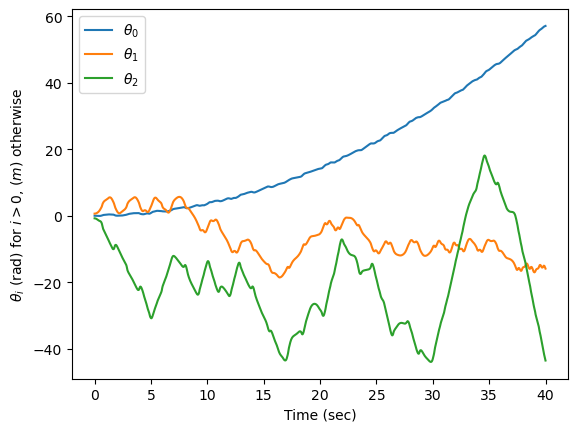

In [81]:
plt.plot(t, the0, label='$\\theta_0$')
plt.plot(t, the1, label='$\\theta_1$')
plt.plot(t, the2, label='$\\theta_2$')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('$\\theta_i$ (rad) for $i>0$, $(m)$ otherwise')

Each row in the "**ans**" matrix yields the $(\theta_0,\dot{\theta_0},\theta_1,\dot{\theta_1},\theta_2,\dot{\theta_2})$ state at time $t$

In [71]:
ans

array([[ 0.00000000e+00,  0.00000000e+00,  6.28318531e-01,
         0.00000000e+00, -7.85398163e-01,  0.00000000e+00],
       [-9.10715866e-04, -4.53950865e-02,  6.36473333e-01,
         4.06585956e-01, -7.96459147e-01, -5.50474958e-01],
       [-3.60991266e-03, -8.91762530e-02,  6.60670452e-01,
         8.00208681e-01, -8.29036056e-01, -1.07113202e+00],
       ...,
       [ 4.54656538e+01,  1.55289420e+00, -5.93347482e+00,
         3.30567021e+00, -5.44286307e+01,  4.09237737e-01],
       [ 4.55276945e+01,  1.54998070e+00, -5.79685625e+00,
         3.53459449e+00, -5.44122992e+01,  3.84807142e-01],
       [ 4.55897597e+01,  1.55519045e+00, -5.64992995e+00,
         3.82210670e+00, -5.43999275e+01,  2.04112252e-01]])

Upon **transposing**, we obtain a matrix of 6 rows corresponding to the values of each variable mentioned above.

In [72]:
ans.T

array([[ 0.00000000e+00, -9.10715866e-04, -3.60991266e-03, ...,
         4.54656538e+01,  4.55276945e+01,  4.55897597e+01],
       [ 0.00000000e+00, -4.53950865e-02, -8.91762530e-02, ...,
         1.55289420e+00,  1.54998070e+00,  1.55519045e+00],
       [ 6.28318531e-01,  6.36473333e-01,  6.60670452e-01, ...,
        -5.93347482e+00, -5.79685625e+00, -5.64992995e+00],
       [ 0.00000000e+00,  4.06585956e-01,  8.00208681e-01, ...,
         3.30567021e+00,  3.53459449e+00,  3.82210670e+00],
       [-7.85398163e-01, -7.96459147e-01, -8.29036056e-01, ...,
        -5.44286307e+01, -5.44122992e+01, -5.43999275e+01],
       [ 0.00000000e+00, -5.50474958e-01, -1.07113202e+00, ...,
         4.09237737e-01,  3.84807142e-01,  2.04112252e-01]])

Having the above data, it is possible to track the location of the pendulums using what we used in **In [18]**

In [82]:
Lsum = L1 + L2
Lmax = Lsum + 0.1
Lmin = -Lmax
the0_min = min(the0)-Lsum
the0_max = max(the0)+Lsum

cartX = 0.2
cartY = 0.1
wheelR = 0.03

def xy_coords(t, the0, the1, the2, L1, L2):
    return (the0,
            0*the0,
            the0 + L1*np.sin(the1),
            L1*np.cos(the1),
            the0 + L1*np.sin(the1) + L2*np.sin(the2),
            L1*np.cos(the1) + L2*np.cos(the2))

x0, y0, x1, y1, x2, y2 = xy_coords(t, ans.T[0], ans.T[2], ans.T[4], L1, L2)

## Animating: RUN THE DEFINITION ABOVE BEFORE ANIMATING! 

In [83]:
xy_corners = np.stack((x0 - cartX/2, y0 - cartY/2), axis=-1)                  # xy coordinates of bottom-left corner of cart
leftW_centers = np.stack((x0 - cartX/4, y0 - (cartY/2 + wheelR)), axis=-1)    # xy coordinates of left wheel of cart
rightW_centers = np.stack((x0 + cartX/4, y0 - (cartY/2 + wheelR)), axis=-1)   # xy coordinates of right wheel of cart

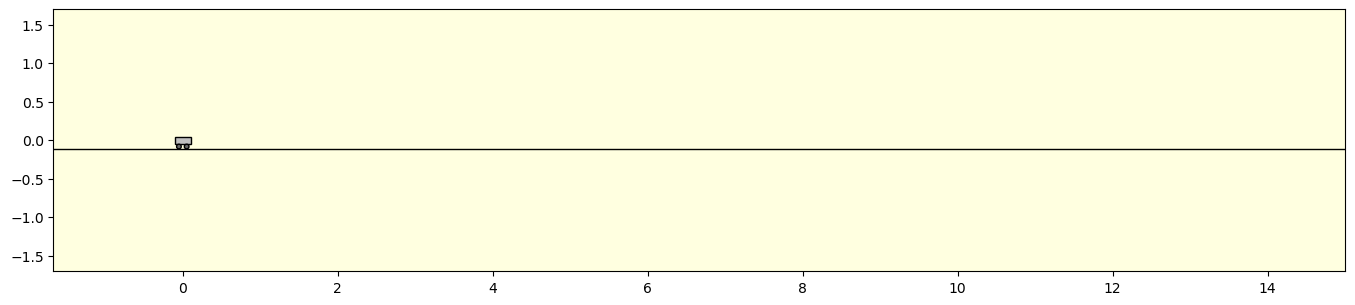

In [84]:
patch = Rectangle(xy_corners[0], cartX, cartY,    # Cart drawing
              edgecolor = 'k',
              facecolor = 'silver',
              fill=True,
              lw=1)
patchW1 = Circle(leftW_centers[0], wheelR,        # Left wheel drawing
              edgecolor = 'k',
              facecolor = 'dimgrey',
              fill=True,
              lw=1)
patchW2 = Circle(rightW_centers[0], wheelR,       # Right wheel drawing
              edgecolor = 'k',
              facecolor = 'dimgrey',
              fill=True,
              lw=1)

def init():
    return (patch, patchW1, patchW2),

def animate(i):
    ln1.set_data([x0[i], x1[i], x2[i]], [y0[i], y1[i], y2[i]])
    patch.set_xy(xy_corners[i])
    patchW1.set_center(leftW_centers[i])
    patchW2.set_center(rightW_centers[i])
    ax.add_patch(patch)
    ax.add_patch(patchW1)
    ax.add_patch(patchW2)

fig, ax = plt.subplots(1,1, figsize=(15-the0_min,2*Lmax))
# fig, ax = plt.subplots(1,1, figsize=(the0_max-the0_min,2*Lmax))
ax.set_facecolor('lightyellow')

ln1, = plt.plot([], [], 'ko-', lw=1, markersize=2)
ax.set_ylim(Lmin,Lmax)
# ax.set_xlim(the0_min,the0_max)
ax.set_xlim(the0_min,15)


patches = [patch, patchW1, patchW2] 
for p in patches:
    ax.add_patch(p)

# Drawing the Cart's "track"
ax.plot([the0_min,the0_max],[-(cartY/2+2*wheelR),-(cartY/2+2*wheelR)],'k-',lw=1)  
# from min to max           # vertical coordinates given that center of cart is at (0,0)

In [85]:
start_time = time.time()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=750)
ani.save('cart_u0_25c_pi5_negpi4_FIXED.gif',writer='pillow',fps=21)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1094.881573677063 seconds ---
